In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob

# plotting/mapmaknig/
import geopandas as gpd
from geospatial_functions import get_background_map
import rasterio
from rasterio.plot import show as rioshow

import warnings

import time

In [2]:
path = os.getcwd()
home_path = os.path.dirname(path)
data_folder = f'{home_path}\\Data'
gis_folder = f'{home_path}\\GIS'

In [3]:
files = glob.glob(f"{data_folder}\\*.parquet")
all_data = pd.read_parquet(files[0])

In [4]:
# loading other layers
outline           = gpd.read_file(f"{gis_folder}\\hudson_basin_26918.gpkg",driver="GPKG",crs="EPSG:26918")
main_rivers       = gpd.read_file(f"{gis_folder}\\main_rivers_hudson_basin.gpkg",driver="GPKG",crs="EPSG:26918")   
all_rivers        = gpd.read_file(f"{gis_folder}\\rivers_hudson_basin.gpkg",driver="GPKG",crs="EPSG:26918")   
gdf_thiessen      = gpd.read_file(f'{gis_folder}\\Thiessen_prcp.shp',crs="EPSG:26918")
# fixing crs
for layer in [outline,main_rivers,all_rivers, gdf_thiessen]:
    layer.geometry = layer.geometry.to_crs("EPSG:4326")

In [5]:
files = glob.glob(f"{data_folder}\\P\\data per station\\*_prcp.csv")

## Load in all precipitation data

In [6]:
df_lst_input = []
station_lst = []
station_index_dict= {}
for index, file in enumerate(files):
    df = pd.read_csv(file, index_col='DATE', usecols=['DATE', 'PRCP', 'STATION', 'LATITUDE', 'LONGITUDE'],  delimiter=',', parse_dates=True)
    station_lst.append([df.iloc[0].STATION,df.iloc[0].LATITUDE, df.iloc[0].LONGITUDE])
    df_lst_input.append(df)
    station_index_dict[f"{df.iloc[0].STATION}"] = index

###  turn this into a dataframe with stations

In [7]:
station_arr = np.array(station_lst)
df_stations = pd.DataFrame(data = list(zip(station_arr[:,0], station_arr[:,1],station_arr[:,2])),columns = ['STATION', 'LATITUDE', 'LONGITUDE'],)
gdf_stations = gpd.GeoDataFrame(data=df_stations, geometry=gpd.points_from_xy(df_stations.LONGITUDE,df_stations.LATITUDE), crs="EPSG:4326")

In [8]:
gdf_stations_in_area = gdf_stations[gdf_stations.within(outline.iloc[0].geometry)]

<AxesSubplot: >

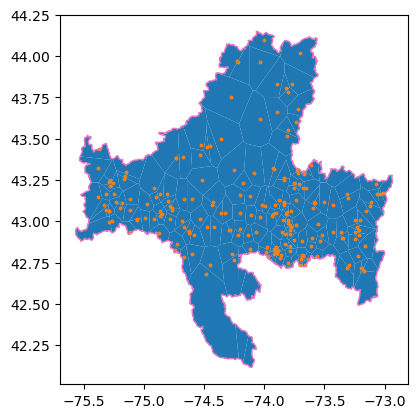

In [9]:
fig, ax = plt.subplots(1)
gdf_thiessen.plot(ax=ax)
gdf_stations_in_area.plot(ax=ax,color="C1",markersize=3) .plot()
outline.plot(ax=ax,edgecolor="C6",facecolor="None")

### perform spatial join to comine the two

In [10]:
gdf_joined = gdf_stations_in_area.sjoin(gdf_thiessen)
gdf_joined.head(5)

,STATION,LATITUDE,LONGITUDE,geometry,index_right,fid,field_1_1,station ID,lat,lon,area
0,US1MABE0018,42.70054,-73.16939,POINT (-73.16939 42.70054),155,582,581,US1MABE0018,42.700540,-73.169390,61.916
16,US1NYAB0037,42.768644,-73.691117,POINT (-73.69112 42.76864),174,647,646,US1NYAB0037,42.768644,-73.691117,12.968
20,US1NYES0005,43.808639,-73.818869,POINT (-73.81887 43.80864),2,41,40,US1NYES0005,43.808639,-73.818869,53.159
21,US1NYES0006,43.8335,-73.89775,POINT (-73.89775 43.83350),3,47,46,US1NYES0006,43.833500,-73.897750,296.634
26,US1NYFL0007,43.039401,-74.108452,POINT (-74.10845 43.03940),202,779,778,US1NYFL0007,43.039401,-74.108452,82.854


weigh the contributions of both

In [11]:
lst_dfs_concat = []
for i in gdf_joined.index:
    station_name = gdf_joined.loc[i,"STATION"]
    station_area = gdf_joined.loc[i,"area"]
    df = df_lst_input[station_index_dict[station_name]][["PRCP"]].copy()
    df.rename(columns={'PRCP':f'{station_name}'},inplace=True)
    lst_dfs_concat.append(df)

In [12]:
df_combined = pd.concat(lst_dfs_concat, axis=1)

The issue is, not all stations overlap, only 4 stations stand between 1950 and 2020, to combat this, we create thiessen polygons for all combinations of stations

In [13]:
n_year = 20 # threshold for the number of years to be opperating
df_selected_combined = df_combined.loc["1950":"2020"].dropna(axis=1,thresh=365*n_year)

In [14]:
df_selected_combined

,USC00300368,USC00300452,USC00300785,USC00300929,USC00301144,USC00301436,USC00301593,USC00301708,USC00302137,USC00302236,...,USC00431786,USC00434882,USC00436500,USC00438160,USW00004782,USW00014735,USW00014750,USW00054768,USW00054781,USW00094794
DATE,,,,,,,,,,,,,,,,,,,,,
1950-01-01,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,...,0.0,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN
1950-01-02,0.0,NaN,2.3,0.5,0.0,0.0,NaN,0.0,0.0,NaN,...,0.0,NaN,NaN,NaN,0.5,1.5,0.3,NaN,NaN,NaN
1950-01-03,0.0,NaN,12.4,2.0,12.7,2.3,NaN,2.8,0.5,NaN,...,6.4,NaN,NaN,NaN,0.0,0.3,1.8,NaN,NaN,NaN
1950-01-04,0.0,NaN,9.1,10.7,0.0,0.0,NaN,2.5,8.1,NaN,...,0.0,NaN,NaN,NaN,0.0,0.0,3.8,NaN,NaN,NaN
1950-01-05,0.0,NaN,0.5,5.3,0.3,0.0,NaN,0.0,1.0,NaN,...,2.5,NaN,NaN,NaN,1.5,2.3,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,NaN,NaN,1.3,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN
2020-12-28,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.3,0.0,0.0,NaN
2020-12-29,NaN,NaN,4.3,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN


In [15]:
df_selected_combined.iloc[:10].apply(lambda x: np.isnan([x.loc[col] for col in x.index])).sum(axis=1)

DATE
1950-01-01    17
1950-01-02    16
1950-01-03    16
1950-01-04    16
1950-01-05    16
1950-01-06    16
1950-01-07    16
1950-01-08    16
1950-01-09    16
1950-01-10    16
dtype: int64

In [16]:
count_nans = df_selected_combined.apply(lambda x: np.isnan([x.loc[col] for col in x.index])).sum(axis=1)

Text(0.5, 1.0, 'Amount of opperating stations')

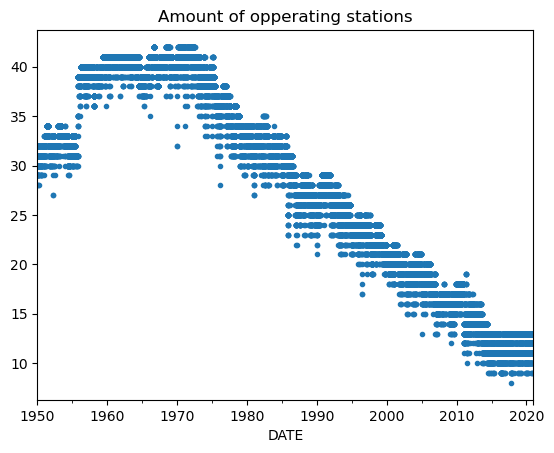

In [17]:
(len(df_selected_combined.columns)- count_nans).plot(lw=0,marker=".")
plt.title("Amount of opperating stations")

In [18]:
columns = np.array(df_selected_combined.columns.to_list())
series_stations_not_na_txt = df_selected_combined.apply(lambda x: ','.join(columns[~np.isnan([x.loc[col] for col in x.index])]),axis=1)
df_stations_not_na_txt = pd.DataFrame(data=series_stations_not_na_txt,columns=["names_station"])
# df_stations_not_na_txt.apply(lambda x: len(x.names_station),axis=1).plot()
len(df_stations_not_na_txt["names_station"].unique())

2609

even with a threshold of 60 years there are already 70. 
>with 50 years per station, there are 478 combinations of stations.<br>
>with 20 there are 2609<br>
>with 10 there are 5844

ajust the n_years parameter to change this, for the purpose of this nb, 20 years is taken as the runtime is still reasonable

**first compute for all combinations of stations**

In [19]:

start = time.time()

In [20]:
series_stations_not_na_ids = df_selected_combined.apply(lambda x: columns[~np.isnan([x.loc[col] for col in x.index])],axis=1)
df_stations_not_na_ids = pd.DataFrame(data=series_stations_not_na_ids,columns=["names_station"])

In [21]:
from longsgis import voronoiDiagram4plg
def draw_thiessen_polygons(stations, boundary):
    """https://pypi.org/project/voronoi-diagram-for-polygons/"""
    warnings.filterwarnings("ignore", category=FutureWarning)
    vd = voronoiDiagram4plg(stations, boundary)
    return vd

In [22]:
total_area = outline.to_crs("EPSG:26918").area.sum()
lst_df_joined = []
dict_df_joined = {}
for index, combination in enumerate(df_stations_not_na_txt['names_station'].unique()):
    ids_to_thiessen = combination.split(",")
    df_station_to_thiessen = gdf_stations_in_area.set_index("STATION").loc[ids_to_thiessen]
    thiessen_polygons = draw_thiessen_polygons(df_station_to_thiessen, outline)
    thiessen_polygons = thiessen_polygons.to_crs("epsg:26918")
    df_station_to_thiessen = df_station_to_thiessen.to_crs("epsg:26918")
    thiessen_polygons["Area_m2"] = thiessen_polygons.area
    df_joined = df_station_to_thiessen.sjoin(thiessen_polygons)
    
    # save the outputs to be used later, dict to get the index, list to store the data
    lst_df_joined.append(df_joined)
    dict_df_joined[combination] = index

In [23]:
len(lst_df_joined)

2609

The dict and list contain all the combinations: thus we then call these when looping over all the days

In [24]:
df_weighted_rain = pd.DataFrame(columns=["P"])
for date, row in df_stations_not_na_txt.iterrows():
    combination_stations = row["names_station"]
    P = lst_df_joined[dict_df_joined[combination_stations]].apply(lambda x: df_lst_input[station_index_dict[x.name]].loc[date, "PRCP"] *x["Area_m2"] /total_area,axis=1).sum()
    df_weighted_rain.loc[date,"P"] = P

In [25]:
mean_p_df = pd.read_parquet(f"{data_folder}\\P\\average_P.parquet")

(-7305.0, 18262.0)

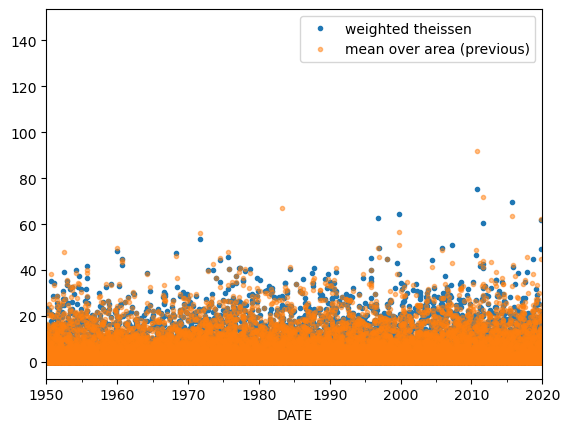

In [26]:
fig, ax = plt.subplots(1)
df_weighted_rain["P"].plot(ax=ax,label="weighted theissen",marker=".",lw=0)
mean_p_df["P"].plot(ax=ax,label="mean over area (previous)",alpha=0.5,lw=0,marker=".")
ax.legend()
ax.set_xlim(["1950","2020"])

In [27]:
end = time.time()
end

1681392120.6350884

In [28]:
print(time)

<module 'time' (built-in)>


the peaks seem better represented

In [29]:
output = False
if output:
    df_weighted_rain.to_parquet(f"{data_folder}\\P\\weighted_average_P_{n_years}.parquet")

example of thiessen polygons:

<AxesSubplot: >

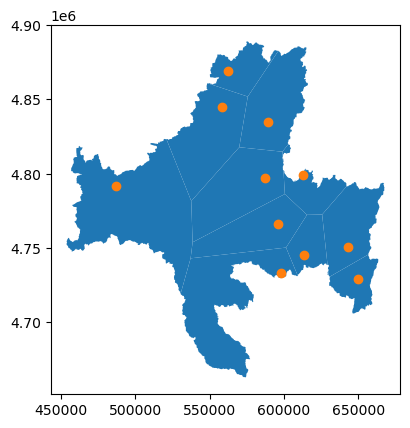

In [30]:
ax = df_station_to_thiessen.plot(color="C1",zorder=10)
thiessen_polygons.plot(ax=ax)

Plot of data start vs dat end

In [31]:
lst_extent = []
for df in df_lst:
    lst_extent.append([df.index.min(),df.index.max()])

NameError: name 'df_lst' is not defined

In [ ]:
arr_extent = np.array(lst_extent)
plt.plot(arr_extent[:,0], arr_extent[:,1],"ro")
plt.xlabel("begin date")
plt.ylabel("end date")